In [1]:
import h5py
import numpy as np
import torch, monai
import torchio as tio
from typing import Sequence
from monai.data import ArrayDataset, DataLoader, PersistentDataset
from monai.transforms import Compose, RandAffine, Rand2DElastic, Rand3DElastic, ScaleIntensity
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
import nibabel as nib
from utils import *
import torch.nn as nn
import itertools

import glob, os
from monai.transforms import (
    Compose,
    LoadImage,
    RandSpatialCrop,
    ScaleIntensity,
    RandFlip,
    RandRotate90
)

from monai.utils import first
from tqdm import tqdm
from utils import *


## 1. Create Dataloader

In [2]:
t1s_dir = 'datasets/IXI/train/t1_align' # Misaligned data # TODO: Put the proper values on 't1_misalign_#'
t2s_dir = 'datasets/IXI/train/t2'

t1s = sorted(glob.glob(os.path.join(t1s_dir, "t1*.npy")))
t2s = sorted(glob.glob(os.path.join(t2s_dir, "t2*.npy")))

t1_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            RandSpatialCrop((96, 96), random_size=False),
            RandFlip(prob=0.5, spatial_axis=0),
            RandFlip(prob=0.5, spatial_axis=1),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )

t2_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            RandSpatialCrop((96, 96), random_size=False),
            RandFlip(prob=0.5, spatial_axis=0),
            RandFlip(prob=0.5, spatial_axis=1),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )


# define array dataset, data loader
train_ds = ArrayDataset(t1s, t1_trans, t2s, t2_trans)
train_loader = DataLoader(train_ds, batch_size=60, num_workers=5, shuffle=True, pin_memory=torch.cuda.is_available())
# This is the trainloader


In [3]:
root_dir = 'datasets/IXI/val'

t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.npy")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.npy")))

t1_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
        ]
    )

t2_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
        ]
    )


# define array dataset, data loader
val_ds = ArrayDataset(t1s, t1_trans, t2s, t2_trans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=5, pin_memory=torch.cuda.is_available())
# This is the val_loader


## 2. Modify the network with monai.GenerativeModels

In [4]:
from GenerativeModels.generative.losses import PatchAdversarialLoss, PerceptualLoss
from GenerativeModels.generative.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.config import print_config
from monai.networks.nets import AttentionUnet
from torch.nn import L1Loss
from tqdm import tqdm
from monai.networks.layers import Act

import time
from GenerativeModels.generative.losses import PatchAdversarialLoss, PerceptualLoss
from GenerativeModels.generative.networks.nets import AutoencoderKL, PatchDiscriminator
print_config()

MONAI version: 1.1.0
Numpy version: 1.24.3
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/milab/anaconda3/envs/danny_misalign/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.5.0
Tensorboard version: 2.13.0
gdown version: 4.7.1
TorchVision version: 0.15.2+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-t

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(2) #TODO: Put the proper values
print(f"Using {device}")

generator_a = AttentionUnet(spatial_dims=2, in_channels=1, out_channels=1, channels=[32,64,128,256], strides=[1,2,2,2]) # Strides: downsampling layers
generator_b = AttentionUnet(spatial_dims=2, in_channels=1, out_channels=1, channels=[32,64,128,256], strides=[1,2,2,2]) # Strides: downsampling layers
generator_a.to(device)
generator_b.to(device)

discriminator_a = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    num_channels=64,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator_b = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    num_channels=64,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator_a.to(device)
discriminator_b.to(device)

# perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="radimagenet_resnet50")
# perceptual_loss.to(device)

optimizer_g = torch.optim.Adam(itertools.chain(generator_a.parameters(),generator_b.parameters()), lr=1e-4)
optimizer_d_a = torch.optim.Adam(params=discriminator_a.parameters(), lr=5e-4)
optimizer_d_b = torch.optim.Adam(params=discriminator_b.parameters(), lr=5e-4)

l1_loss = L1Loss()
adv_loss = PatchAdversarialLoss(criterion="least_squares")
cycle_weight = 100

# CGAN : adv_loss + cycle_loss

Using cuda


Saving directroy: ./checkpoints/cGAN_run4


Epoch 0:   0%|                                                                         | 0/38 [00:00<?, ?it/s]/home/milab/anaconda3/envs/danny_misalign/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/milab/anaconda3/envs/danny_misalign/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/milab/anaconda3/envs/danny_misalign/lib/python3.9/site-packages/torc

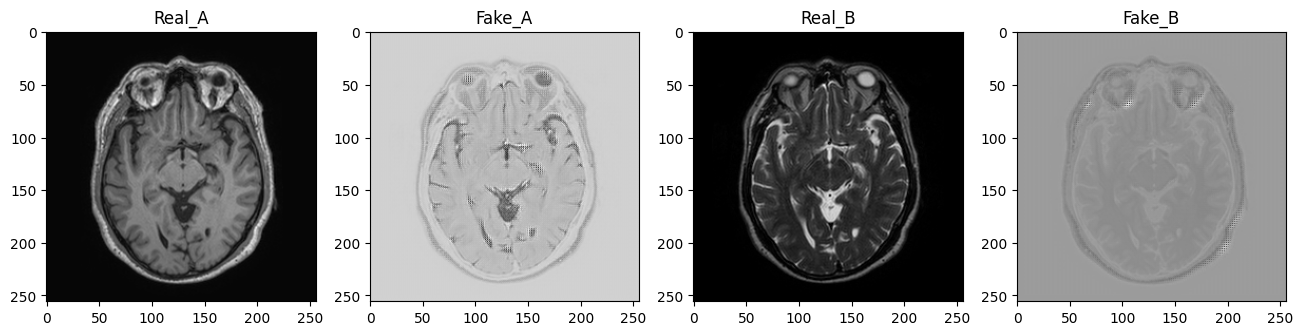

Validation T1 Loss:  0.24720148061003003 Average T1 PSNR:  11.191007012587328 Average T1 SSIM:  -0.020443657954008532
Validation T2 Loss:  0.19624305229920608 Average T2 PSNR:  13.222334538973294 Average T2 SSIM:  0.031020302160254937


Epoch 20: 100%|█| 38/38 [00:21<00:00,  1.81it/s, cycle_a_loss=0.0157, cycle_b_loss=0.0158, gen_a_loss=1.02, ge
Epoch 21: 100%|█| 38/38 [00:20<00:00,  1.81it/s, cycle_a_loss=0.0158, cycle_b_loss=0.0166, gen_a_loss=1.03, ge
Epoch 22: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.0164, cycle_b_loss=0.0178, gen_a_loss=1.07, ge
Epoch 23: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.015, cycle_b_loss=0.0158, gen_a_loss=0.956, ge
Epoch 24: 100%|█| 38/38 [00:20<00:00,  1.81it/s, cycle_a_loss=0.0149, cycle_b_loss=0.015, gen_a_loss=0.61, gen
Epoch 25: 100%|█| 38/38 [00:21<00:00,  1.81it/s, cycle_a_loss=0.0144, cycle_b_loss=0.0151, gen_a_loss=0.789, g
Epoch 26: 100%|█| 38/38 [00:21<00:00,  1.81it/s, cycle_a_loss=0.0139, cycle_b_loss=0.0144, gen_a_loss=0.889, g
Epoch 27: 100%|█| 38/38 [00:21<00:00,  1.81it/s, cycle_a_loss=0.0133, cycle_b_loss=0.014, gen_a_loss=0.915, ge
Epoch 28: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.0133, cycle_b_loss=0.0141, gen_a_loss=0.896, g
E

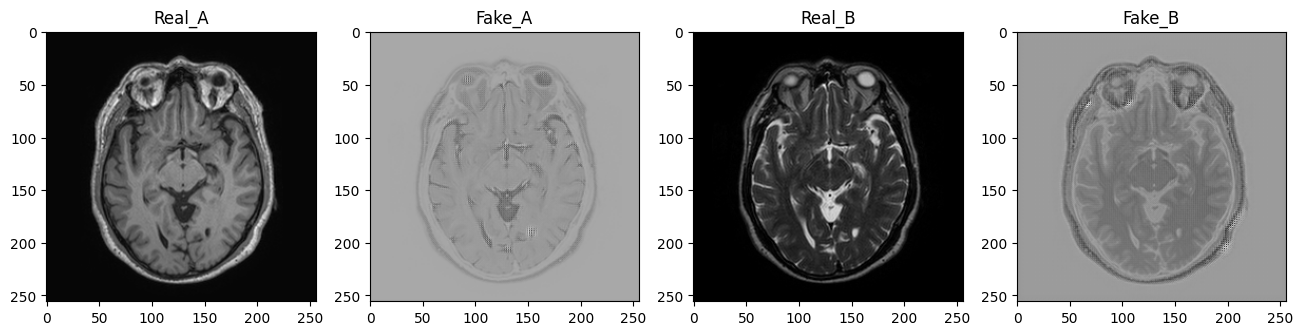

Validation T1 Loss:  0.2516492166034468 Average T1 PSNR:  11.282714671879024 Average T1 SSIM:  -0.016241777140856978
Validation T2 Loss:  0.20445505249631274 Average T2 PSNR:  13.045207956335046 Average T2 SSIM:  0.014408906919697484


Epoch 40: 100%|█| 38/38 [00:20<00:00,  1.81it/s, cycle_a_loss=0.0127, cycle_b_loss=0.013, gen_a_loss=1.01, gen
Epoch 41: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.0123, cycle_b_loss=0.0123, gen_a_loss=0.997, g
Epoch 42: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.0109, cycle_b_loss=0.0125, gen_a_loss=1.01, ge
Epoch 43: 100%|█| 38/38 [00:21<00:00,  1.81it/s, cycle_a_loss=0.0118, cycle_b_loss=0.013, gen_a_loss=1.03, gen
Epoch 44: 100%|█| 38/38 [00:21<00:00,  1.81it/s, cycle_a_loss=0.0113, cycle_b_loss=0.0123, gen_a_loss=0.987, g
Epoch 45: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.0114, cycle_b_loss=0.0125, gen_a_loss=1, gen_b
Epoch 46: 100%|█| 38/38 [00:21<00:00,  1.81it/s, cycle_a_loss=0.0107, cycle_b_loss=0.013, gen_a_loss=1.01, gen
Epoch 47: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.0112, cycle_b_loss=0.0126, gen_a_loss=0.998, g
Epoch 48: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.0104, cycle_b_loss=0.0122, gen_a_loss=0.998, g
E

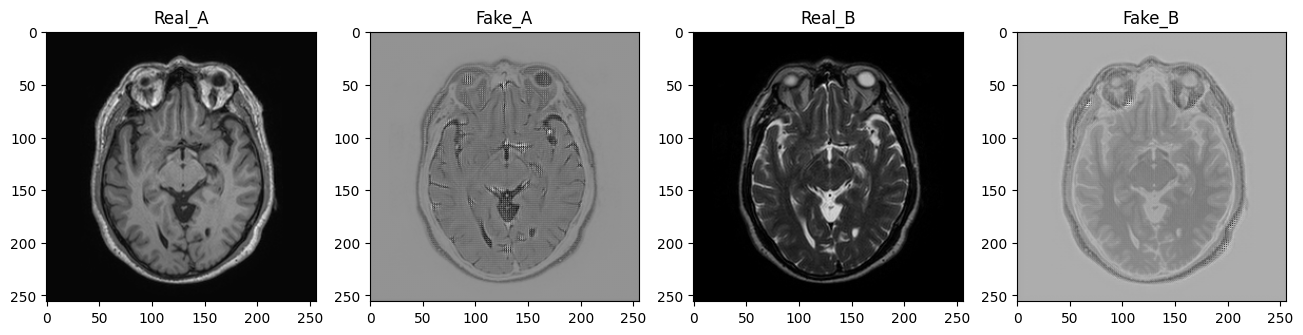

Validation T1 Loss:  0.2505295421395983 Average T1 PSNR:  11.348535741030515 Average T1 SSIM:  -0.030164850494990816
Validation T2 Loss:  0.20479918734712915 Average T2 PSNR:  13.061020811311492 Average T2 SSIM:  0.0015541173523061034


Epoch 60: 100%|█| 38/38 [00:21<00:00,  1.78it/s, cycle_a_loss=0.00959, cycle_b_loss=0.0104, gen_a_loss=1.01, g
Epoch 61: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.00988, cycle_b_loss=0.011, gen_a_loss=1.01, ge
Epoch 62: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00938, cycle_b_loss=0.0106, gen_a_loss=1.01, g
Epoch 63: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.011, cycle_b_loss=0.0123, gen_a_loss=1.05, gen
Epoch 64: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00925, cycle_b_loss=0.0106, gen_a_loss=1.03, g
Epoch 65: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.0093, cycle_b_loss=0.0105, gen_a_loss=1.01, ge
Epoch 66: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.0094, cycle_b_loss=0.0105, gen_a_loss=1.01, ge
Epoch 67: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.0091, cycle_b_loss=0.0103, gen_a_loss=1.01, ge
Epoch 68: 100%|█| 38/38 [00:21<00:00,  1.81it/s, cycle_a_loss=0.00931, cycle_b_loss=0.00973, gen_a_loss=1.01, 
E

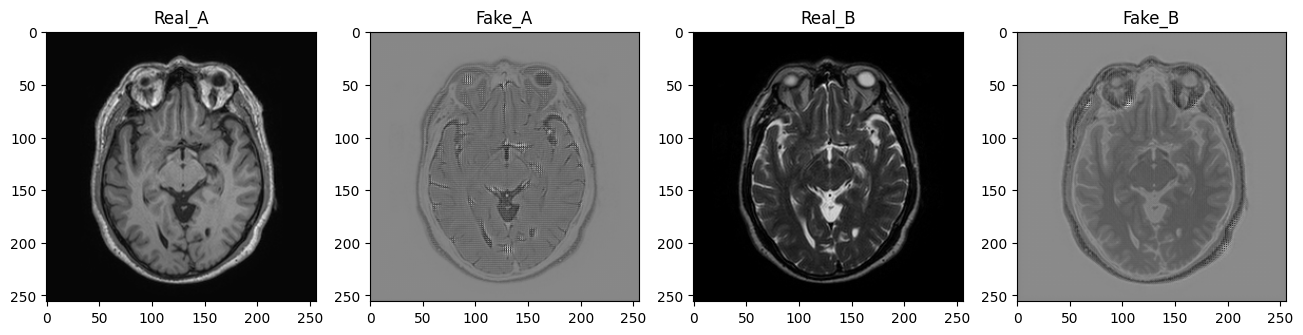

Validation T1 Loss:  0.2461930710535783 Average T1 PSNR:  11.596374457223074 Average T1 SSIM:  -0.022103790419302872
Validation T2 Loss:  0.20871528075946558 Average T2 PSNR:  12.925969763116521 Average T2 SSIM:  0.0051790678566788675


Epoch 80: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00834, cycle_b_loss=0.00952, gen_a_loss=1, gen
Epoch 81: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00834, cycle_b_loss=0.00942, gen_a_loss=1, gen
Epoch 82: 100%|█| 38/38 [00:21<00:00,  1.81it/s, cycle_a_loss=0.00873, cycle_b_loss=0.00969, gen_a_loss=1.02, 
Epoch 83: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.0086, cycle_b_loss=0.00921, gen_a_loss=1, gen_
Epoch 84: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00858, cycle_b_loss=0.00971, gen_a_loss=1, gen
Epoch 85: 100%|█| 38/38 [00:21<00:00,  1.81it/s, cycle_a_loss=0.0087, cycle_b_loss=0.00964, gen_a_loss=1.01, g
Epoch 86: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.00858, cycle_b_loss=0.00978, gen_a_loss=1.02, 
Epoch 87: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.00895, cycle_b_loss=0.00974, gen_a_loss=1.01, 
Epoch 88: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.0084, cycle_b_loss=0.00985, gen_a_loss=1.01, g
E

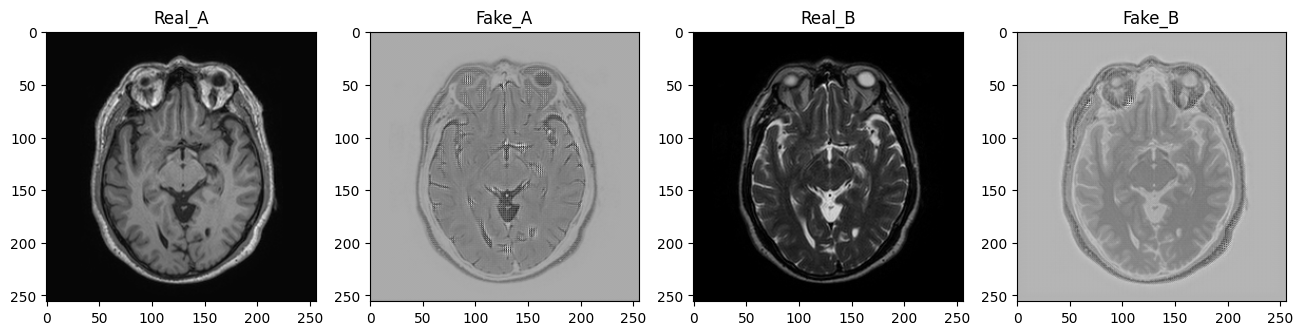

Validation T1 Loss:  0.2577601562162022 Average T1 PSNR:  11.192654330913838 Average T1 SSIM:  -0.03625661279560977
Validation T2 Loss:  0.20340865745649234 Average T2 PSNR:  13.15678073128501 Average T2 SSIM:  0.026844258693645415


Epoch 100: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00853, cycle_b_loss=0.00999, gen_a_loss=1.01,
Epoch 101: 100%|█| 38/38 [00:21<00:00,  1.78it/s, cycle_a_loss=0.00831, cycle_b_loss=0.00984, gen_a_loss=1.02,
Epoch 102: 100%|█| 38/38 [00:21<00:00,  1.81it/s, cycle_a_loss=0.0077, cycle_b_loss=0.00859, gen_a_loss=1.02, 
Epoch 103: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00751, cycle_b_loss=0.00877, gen_a_loss=1.01,
Epoch 104: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00744, cycle_b_loss=0.00887, gen_a_loss=1.01,
Epoch 105: 100%|█| 38/38 [00:21<00:00,  1.81it/s, cycle_a_loss=0.00744, cycle_b_loss=0.00877, gen_a_loss=1.01,
Epoch 106: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.0077, cycle_b_loss=0.00853, gen_a_loss=1.02, 
Epoch 107: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.00722, cycle_b_loss=0.0084, gen_a_loss=1.01, 
Epoch 108: 100%|█| 38/38 [00:21<00:00,  1.81it/s, cycle_a_loss=0.0079, cycle_b_loss=0.0087, gen_a_loss=1.01, g
E

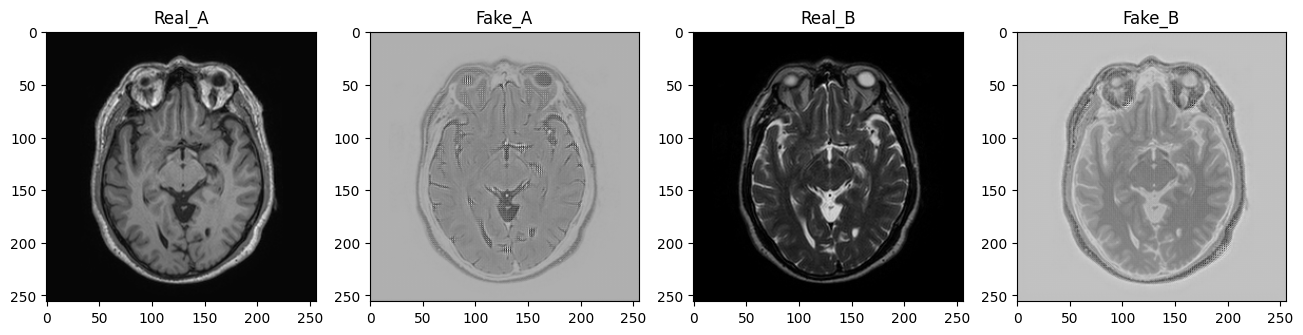

Validation T1 Loss:  0.2507184006683119 Average T1 PSNR:  11.460000591487676 Average T1 SSIM:  -0.02666412035628877
Validation T2 Loss:  0.20817231411462303 Average T2 PSNR:  12.97974892291394 Average T2 SSIM:  0.014765424500884755


Epoch 120: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00779, cycle_b_loss=0.00854, gen_a_loss=1.01,
Epoch 121: 100%|█| 38/38 [00:20<00:00,  1.81it/s, cycle_a_loss=0.00752, cycle_b_loss=0.00807, gen_a_loss=1.01,
Epoch 122: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00688, cycle_b_loss=0.00793, gen_a_loss=1.01,
Epoch 123: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.00846, cycle_b_loss=0.00926, gen_a_loss=1.01,
Epoch 124: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00731, cycle_b_loss=0.00818, gen_a_loss=1.01,
Epoch 125: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.0074, cycle_b_loss=0.00804, gen_a_loss=1.02, 
Epoch 126: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00721, cycle_b_loss=0.00795, gen_a_loss=1.02,
Epoch 127: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00725, cycle_b_loss=0.00802, gen_a_loss=1.01,
Epoch 128: 100%|█| 38/38 [00:21<00:00,  1.78it/s, cycle_a_loss=0.00676, cycle_b_loss=0.00821, gen_a_loss=1.01,
E

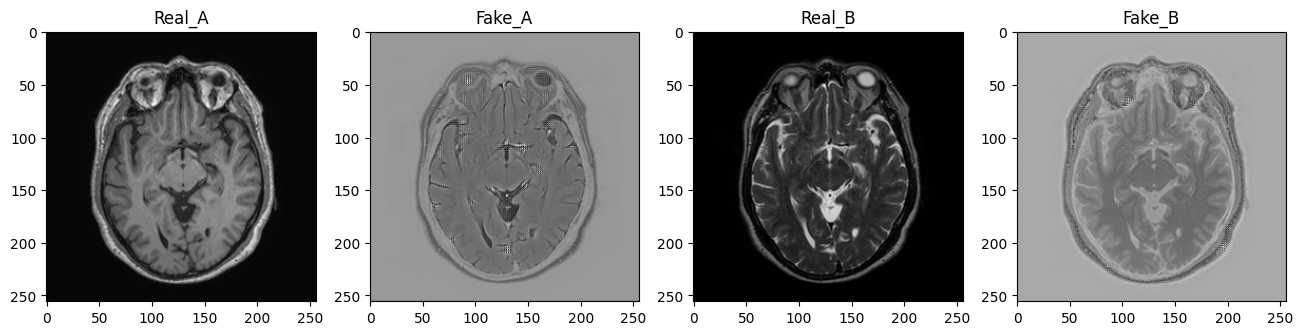

Validation T1 Loss:  0.25368340480458607 Average T1 PSNR:  11.402722643757915 Average T1 SSIM:  -0.024496529546053313
Validation T2 Loss:  0.20293687880039216 Average T2 PSNR:  13.193723976219093 Average T2 SSIM:  0.02157184392457526


Epoch 140: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.00666, cycle_b_loss=0.0076, gen_a_loss=1.01, 
Epoch 141: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00716, cycle_b_loss=0.008, gen_a_loss=1.02, g
Epoch 142: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.00727, cycle_b_loss=0.00816, gen_a_loss=1.01,
Epoch 143: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.00819, cycle_b_loss=0.00829, gen_a_loss=1.01,
Epoch 144: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.00701, cycle_b_loss=0.00803, gen_a_loss=1.01,
Epoch 145: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00738, cycle_b_loss=0.00816, gen_a_loss=1.01,
Epoch 146: 100%|█| 38/38 [00:21<00:00,  1.79it/s, cycle_a_loss=0.00737, cycle_b_loss=0.00894, gen_a_loss=1.02,
Epoch 147: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00778, cycle_b_loss=0.00795, gen_a_loss=1.01,
Epoch 148: 100%|█| 38/38 [00:21<00:00,  1.80it/s, cycle_a_loss=0.00663, cycle_b_loss=0.00769, gen_a_loss=1.01,
E

In [6]:
# Example from : https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/2d_autoencoderkl/2d_autoencoderkl_tutorial.ipynb

from torch.nn.functional import mse_loss
from pytorch_msssim import ssim

n_epochs = 300
val_interval = 20
epoch_cycle_a_loss_list = []
epoch_cycle_b_loss_list = []
epoch_gen_a_loss_list = []
epoch_gen_b_loss_list = []
epoch_disc_a_loss_list = []
epoch_disc_b_loss_list = []
val_t1_recon_epoch_loss_list = []
val_t2_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4
train_save_dir = './checkpoints/cGAN_run'
base_dir = train_save_dir

# Check if directory exists. If it does, append a number to it
i = 1
while os.path.exists(train_save_dir):
    train_save_dir = base_dir + str(i)
    i += 1

os.makedirs(train_save_dir, exist_ok=True)
print("Saving directroy:", train_save_dir)

total_start = time.time()
for epoch in range(n_epochs):
    generator_a.train()
    generator_b.train()
    discriminator_a.train()
    discriminator_b.train()
    cycle_a_epoch_loss = 0
    cycle_b_epoch_loss = 0
    gen_a_epoch_loss = 0
    gen_b_epoch_loss = 0
    disc_a_epoch_loss = 0
    disc_b_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, (t1,t2) in progress_bar:
        t1 = t1.to(device)
        t2 = t2.to(device)
        # Generator part (Updating generator)
        optimizer_g.zero_grad(set_to_none=True)

        fake_t2 = generator_a(t1)
        pred_fake = discriminator_a(fake_t2.contiguous().float())[-1]
        loss_g_a = adv_loss(pred_fake, target_is_real=True, for_discriminator=False)

        fake_t1 = generator_b(t2)
        pred_fake = discriminator_b(fake_t1.contiguous().float())[-1]
        loss_g_b = adv_loss(pred_fake, target_is_real=True, for_discriminator=False)
        
        rec_a = generator_b(fake_t2)
        loss_cycle_a = l1_loss(t1.float(), rec_a.float())
        
        rec_b = generator_a(fake_t1)
        loss_cycle_b = l1_loss(t2,rec_b)

        loss_g = loss_g_a + loss_g_b + (loss_cycle_a * cycle_weight) + (loss_cycle_b * cycle_weight) # cycle_weight: 100 (default)

        loss_g.backward()
        optimizer_g.step()

        # Discriminator part (Updating discriminator)
        optimizer_d_a.zero_grad(set_to_none=True)
        pred_real_t2 = discriminator_a(t2.contiguous())[-1]
        loss_d_real_t2 = adv_loss(pred_real_t2, target_is_real=True, for_discriminator=True)
        pred_fake_t2 = discriminator_a(fake_t2.contiguous().detach())[-1]
        loss_d_fake_t2 = adv_loss(pred_fake_t2, target_is_real=False, for_discriminator=True)
        loss_d_a = (loss_d_real_t2 + loss_d_fake_t2) * 0.5
        loss_d_a.backward()
        optimizer_d_a.step()

        optimizer_d_b.zero_grad(set_to_none=True)
        pred_real_t1 = discriminator_b(t1.contiguous())[-1]
        loss_d_real_t1 = adv_loss(pred_real_t1, target_is_real=True, for_discriminator=True)
        pred_fake_t1 = discriminator_b(fake_t1.contiguous().detach())[-1]
        loss_d_fake_t1 = adv_loss(pred_fake_t1, target_is_real=False, for_discriminator=True)
        loss_d_b = (loss_d_real_t1 + loss_d_fake_t1) * 0.5
        loss_d_b.backward()
        optimizer_d_b.step()


        cycle_a_epoch_loss += loss_cycle_a.item()
        cycle_b_epoch_loss += loss_cycle_b.item()
        gen_a_epoch_loss += loss_g_a.item()
        gen_b_epoch_loss += loss_g_b.item()
        disc_a_epoch_loss += loss_d_a.item()
        disc_b_epoch_loss += loss_d_b.item()

        progress_bar.set_postfix(
            {
                "cycle_a_loss": cycle_a_epoch_loss / (step + 1),
                "cycle_b_loss": cycle_b_epoch_loss / (step + 1),
                "gen_a_loss": gen_a_epoch_loss / (step + 1),
                "gen_b_loss": gen_b_epoch_loss / (step + 1),
                "disc_a_loss": disc_a_epoch_loss / (step + 1),
                "disc_b_loss": disc_b_epoch_loss / (step + 1),
            }
        )
    epoch_cycle_a_loss_list.append(cycle_a_epoch_loss / (step + 1))
    epoch_cycle_b_loss_list.append(cycle_b_epoch_loss / (step + 1))
    epoch_gen_a_loss_list.append(gen_a_epoch_loss / (step + 1))
    epoch_gen_b_loss_list.append(gen_b_epoch_loss / (step + 1))
    epoch_disc_a_loss_list.append(disc_a_epoch_loss / (step + 1))
    epoch_disc_b_loss_list.append(disc_b_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:

        # Save the model
        model_save_path = os.path.join(train_save_dir, f'model_G_a_epoch_{epoch+1}.pth')
        torch.save(generator_a.state_dict(), model_save_path)
        model_save_path = os.path.join(train_save_dir, f'model_G_b_epoch_{epoch+1}.pth')
        torch.save(generator_b.state_dict(), model_save_path)
        model_save_path = os.path.join(train_save_dir, f'model_D_a_epoch_{epoch+1}.pth')
        torch.save(discriminator_a.state_dict(), model_save_path)
        model_save_path = os.path.join(train_save_dir, f'model_D_b_epoch_{epoch+1}.pth')
        torch.save(discriminator_b.state_dict(), model_save_path)
        

        generator_a.eval()
        generator_b.eval()
        val_t1_loss = 0
        val_t2_loss = 0
        total_psnr_t1 = 0
        total_psnr_t2 = 0
        total_ssim_t1 = 0
        total_ssim_t2 = 0
        with torch.no_grad():
            for val_step, (t1,t2) in enumerate(val_loader, start=1):
                t1 = t1.to(device)
                t2 = t2.to(device)
                fake_t2 = generator_a(t1)
                fake_t1 = generator_b(t2)



                # get the first sammple from the first validation batch for visualisation
                # purposes
                recons_t1_loss = l1_loss(fake_t1.float(), t1.float())
                recons_t2_loss = l1_loss(fake_t2.float(), t2.float())

                val_t1_loss += recons_t1_loss.item()
                val_t2_loss += recons_t2_loss.item()

                 # Calculate PSNR
                mse_val_t1 = mse_loss(fake_t1.float(), t1.float())
                mse_val_t2 = mse_loss(fake_t2.float(), t2.float())
                psnr_t1 = 10 * torch.log10(1 / mse_val_t1)
                psnr_t2 = 10 * torch.log10(1 / mse_val_t2)
                total_psnr_t1 += psnr_t1.item()
                total_psnr_t2 += psnr_t2.item()

                # Calculate SSIM
                ssim_val_t1 = ssim(fake_t1.float(), t1.float(), data_range=1.0, size_average=True) # data_range: 0~1
                total_ssim_t1 += ssim_val_t1.item()
                ssim_val_t2 = ssim(fake_t2.float(), t2.float(), data_range=1.0, size_average=True) # data_range: 0~1
                total_ssim_t2 += ssim_val_t2.item()

                if val_step == 25:
                    # intermediary_images.append(reconstruction[:n_example_images, 0])
                    out = get_current_visuals_for_cgan(t1.float(),fake_t1.float(),t2.float(),fake_t2.float())
                    images = [out['real_A'], out['fake_A'], out['real_B'], out['fake_B']]
                    image_names = ['Real_A', 'Fake_A', 'Real_B', 'Fake_B']
                    image_save_dir = os.path.join(train_save_dir,'val_images')
                    os.makedirs(image_save_dir, exist_ok=True)
                    plot_images(images, image_names)
                    save_images(images, image_names, image_save_dir, epoch+1)

        val_t1_loss /= val_step
        val_t2_loss /= val_step
        val_t1_recon_epoch_loss_list.append(val_t1_loss)
        val_t2_recon_epoch_loss_list.append(val_t2_loss)
        
        avg_psnr_t1 = total_psnr_t1 / val_step
        avg_psnr_t2 = total_psnr_t2 / val_step
        avg_ssim_t1 = total_ssim_t1 / val_step
        avg_ssim_t2 = total_ssim_t2 / val_step

         # Print the PSNR and SSIM values along with the loss
        print("Validation T1 Loss: ", val_t1_loss, "Average T1 PSNR: ", avg_psnr_t1, "Average T1 SSIM: ", avg_ssim_t1)
        print("Validation T2 Loss: ", val_t2_loss, "Average T2 PSNR: ", avg_psnr_t2, "Average T2 SSIM: ", avg_ssim_t2)
        with open(os.path.join(train_save_dir, 'val_PSNR,SSIM.txt'), 'a') as f:
            f.write(f'Epoch: {epoch+1}, Val T1 Loss: {val_t1_loss}, T1 PSNR: {avg_psnr_t1}, T1 SSIM: {avg_ssim_t1}\n')
            f.write(f'Epoch: {epoch+1}, Val T2 Loss: {val_t2_loss}, T2 PSNR: {avg_psnr_t2}, T2 SSIM: {avg_ssim_t2}\n')


total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")